🗑️ Deleting existing repository at '/content/magnetic-field-predictor'...
🔄 Cloning the repository...

=== Magnetic Field Predictor ===
1. Train Model with CSV
2. Predict from CSV
3. Predict from Input Values
4. Exit
Enter your choice (1/2/3/4): 2

📁 Available CSV files in 'data/':
1. predictnew.csv
2. synthetic_data.csv
3. tt.csv
4. train2.csv
5. predict.csv
6. decimaltrain.csv
7. finalt.csv
8. train.csv
9. predictnew (1).csv
Enter number (1–9): 5

📊 RMSE: 2.579806e-07 T
📊 Relative RMSE: 13.75%
📊 R² Score: 0.9884 (closer to 1 is better)

🔍 Prediction Results :
    Current(A)  Radius(m)  True_MagneticField  Predicted_MagneticField
0    24.512053   0.960350        5.104814e-06             5.561718e-06
1    29.810266   3.755079        1.587730e-06             1.594337e-06
2    33.956524   3.206939        2.117691e-06             2.099957e-06
3    34.789524   8.941748        7.781370e-07             7.469974e-07
4    40.217910   9.064526        8.873693e-07             8.378328e-07
5    1

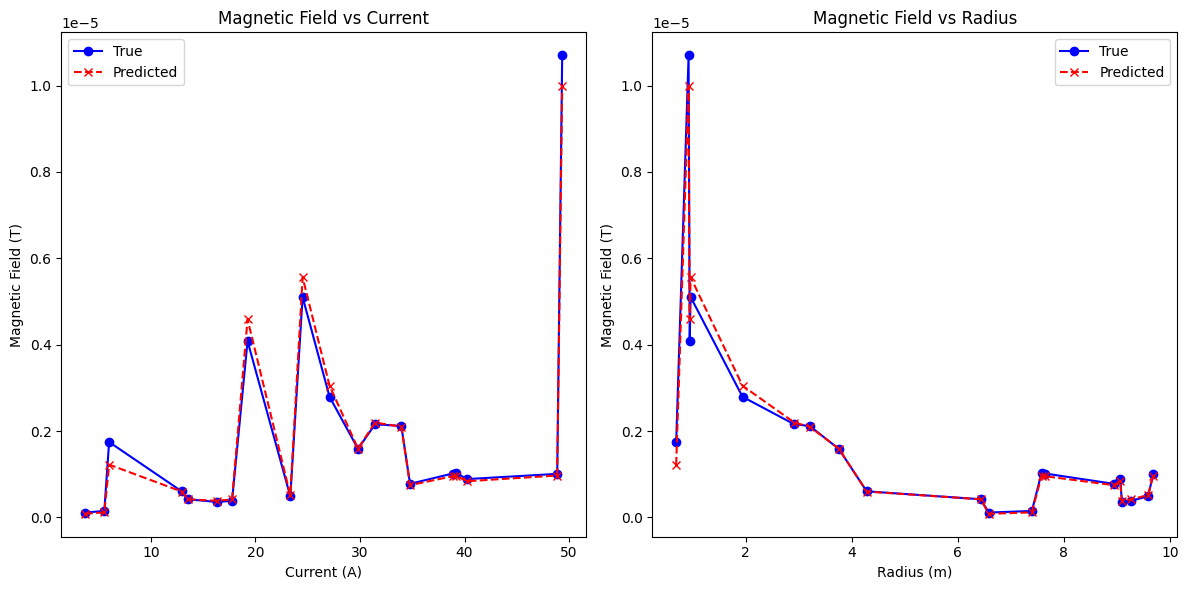


=== Magnetic Field Predictor ===
1. Train Model with CSV
2. Predict from CSV
3. Predict from Input Values
4. Exit


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# --- Helper functions ---
def apply_log_transformation(df):
    df["Log_MagneticField"] = np.log(df["MagneticField"] + 1e-10)  # Avoid log(0)
    return df

def add_noise_to_data(df, noise_level=0.05):
    """
    Add Gaussian noise to the MagneticField values to simulate real-world data.
    noise_level is the standard deviation of the noise (as a fraction of the true value).
    """
    noise = np.random.normal(0, noise_level, size=df["MagneticField"].shape)  # Adding noise
    df["MagneticField"] += noise
    return df


def choose_csv_file(folder="data"):
    repo_folder = '/content/magnetic-field-predictor/' + folder  # Path to the cloned repo folder
    if not os.path.exists(repo_folder):
        print(f"❌ Folder '{folder}' not found in the repo. Please check if the folder exists.")
        return None

    try:
        files = [f for f in os.listdir(repo_folder) if f.endswith(".csv")]
        if not files:
            print(f"❌ No CSV files found in '{folder}/'")
            return None

        print(f"\n📁 Available CSV files in '{folder}/':")
        for idx, file in enumerate(files, 1):
            print(f"{idx}. {file}")
        choice = input(f"Enter number (1–{len(files)}): ")

        idx = int(choice) - 1
        if 0 <= idx < len(files):
            return os.path.join(repo_folder, files[idx])
        else:
            print("❌ Invalid choice.")
            return None
    except Exception as e:
        print(f"⚠ Error: {e}")
        return None

def feature_engineering(df):
    # Keep only I_over_R, I_x_R, Current_squared, and Radius_squared
    df["I_over_R"] = df["Current(A)"] / df["Radius(m)"]
    df["I_x_R"] = df["Current(A)"] * df["Radius(m)"]
    df["Current_squared"] = df["Current(A)"] ** 2  # Adding Current squared feature
    df["Radius_squared"] = df["Radius(m)"] ** 2  # Adding Radius squared feature
    return df


def train_model_with_csv(train_filename, degree=4, model_path='linear_model.pkl'):
    df = pd.read_csv(train_filename)
    df.columns = df.columns.str.strip()
    df.rename(columns={'MagneticField(T)': 'MagneticField'}, inplace=True, errors='ignore')

    df = apply_log_transformation(df)
    df = feature_engineering(df)  # Apply simplified feature engineering

    # Prepare features, adding the new squared features
    X = df[["Current(A)", "Radius(m)", "I_over_R", "I_x_R", "Current_squared", "Radius_squared"]]  # Include new features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)

    model = LinearRegression()
    model.fit(X_poly, df["Log_MagneticField"])

    # Save the model, polynomial features, and scaler to disk
    joblib.dump((model, poly, scaler), model_path)
    print("✅ Model trained and saved successfully.")


def predict_from_csv(predict_filename, model_path='linear_model.pkl'):
    # Load the trained model, polynomial features, and scaler
    try:
        model, poly, scaler = joblib.load(model_path)
    except FileNotFoundError:
        print(f"❌ No trained model found at '{model_path}'. Please train the model first.")
        return

    df = pd.read_csv(predict_filename)
    df.columns = df.columns.str.strip()
    df.rename(columns={'MagneticField(T)': 'MagneticField'}, inplace=True, errors='ignore')

    df = feature_engineering(df)  # Apply simplified feature engineering

    # Prepare features
    X = df[["Current(A)", "Radius(m)", "I_over_R", "I_x_R", "Current_squared", "Radius_squared"]]  # Include new features
    X_scaled = scaler.transform(X)
    X_poly = poly.transform(X_scaled)

    df["Predicted_Log_MagneticField"] = model.predict(X_poly)
    df["Predicted_MagneticField"] = np.exp(df["Predicted_Log_MagneticField"]) - 1e-10
    df["True_MagneticField"] = df["MagneticField"]

    # RMSE
    rmse = np.sqrt(mean_squared_error(df["True_MagneticField"], df["Predicted_MagneticField"]))

    # Relative RMSE (% of mean value)
    mean_true = df["True_MagneticField"].mean()
    relative_rmse = (rmse / mean_true) * 100 if mean_true != 0 else 0

    # R² score
    r2 = r2_score(df["True_MagneticField"], df["Predicted_MagneticField"])

    # Display results
    print(f"\n📊 RMSE: {rmse:.6e} T")
    print(f"📊 Relative RMSE: {relative_rmse:.2f}%")
    print(f"📊 R² Score: {r2:.4f} (closer to 1 is better)")
    print("\n🔍 Prediction Results :")
    print(df[["Current(A)", "Radius(m)", "True_MagneticField", "Predicted_MagneticField"]].head(df.shape[0]))
    print(df.sort_values(by="Current(A)"))

    plot_line_comparison(df)


def predict_from_input(model_path='linear_model.pkl'):
    # Load the trained model, polynomial features, and scaler
    try:
        model, poly, scaler = joblib.load(model_path)
    except FileNotFoundError:
        print(f"❌ No trained model found at '{model_path}'. Please train the model first.")
        return

    try:
        current = float(input("Enter Current (A): "))
        radius = float(input("Enter Radius (m): "))
    except ValueError:
        print("❌ Invalid input. Please enter numeric values.")
        return

    # Apply feature engineering
    df_input = pd.DataFrame([[current, radius]], columns=["Current(A)", "Radius(m)"])
    df_input = feature_engineering(df_input)  # Apply the same feature engineering

    # Prepare the input features (including squared features)
    X = df_input[["Current(A)", "Radius(m)", "I_over_R", "I_x_R", "Current_squared", "Radius_squared"]]
    X_scaled = scaler.transform(X)  # Use the same scaler for input features
    X_poly = poly.transform(X_scaled)  # Transform using the same polynomial features

    # Make the prediction
    pred_log = model.predict(X_poly)[0]  # Get the predicted log magnetic field
    pred = np.exp(pred_log) - 1e-10  # Convert back to magnetic field

    print(f"🧲 Predicted Magnetic Field: {pred:.7e} T")


def plot_line_comparison(df):
    plt.figure(figsize=(12, 6))

    df_sorted = df.sort_values(by="Current(A)")
    plt.subplot(1, 2, 1)
    plt.plot(df_sorted["Current(A)"], df_sorted["True_MagneticField"], label="True", color="blue", marker="o")
    plt.plot(df_sorted["Current(A)"], df_sorted["Predicted_MagneticField"], label="Predicted", color="red", marker="x", linestyle="--")
    plt.xlabel("Current (A)")
    plt.ylabel("Magnetic Field (T)")
    plt.title("Magnetic Field vs Current")
    plt.legend()

    df_sorted_r = df.sort_values(by="Radius(m)")
    plt.subplot(1, 2, 2)
    plt.plot(df_sorted_r["Radius(m)"], df_sorted_r["True_MagneticField"], label="True", color="blue", marker="o")
    plt.plot(df_sorted_r["Radius(m)"], df_sorted_r["Predicted_MagneticField"], label="Predicted", color="red", marker="x", linestyle="--")
    plt.xlabel("Radius (m)")
    plt.ylabel("Magnetic Field (T)")
    plt.title("Magnetic Field vs Radius")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Main Menu ---
def main():
    # Check if the repo exists, and delete if necessary
    repo_path = '/content/magnetic-field-predictor'
    if os.path.exists(repo_path):
        print(f"🗑️ Deleting existing repository at '{repo_path}'...")
        shutil.rmtree(repo_path)

    print("🔄 Cloning the repository...")
    os.system('git clone https://github.com/JustBored010/magnetic-field-predictor.git')

    while True:
        print("\n=== Magnetic Field Predictor ===")
        print("1. Train Model with CSV")
        print("2. Predict from CSV")
        print("3. Predict from Input Values")
        print("4. Exit")
        choice = input("Enter your choice (1/2/3/4): ")

        if choice == '1':
            train_filename = choose_csv_file("data")  # Choose file from the data folder in the repo
            if train_filename:
                train_model_with_csv(train_filename, degree=4)
        elif choice == '2':
            predict_filename = choose_csv_file("data")  # Choose file from the data folder in the repo
            if predict_filename:
                predict_from_csv(predict_filename)
        elif choice == '3':
            predict_from_input()
        elif choice == '4':
            print("👋 Exiting program.")
            break  # This will exit the program if the user selects "Exit"
        else:
            print("❌ Invalid choice. Please try again.")

if __name__ == "__main__":
    main()
